5장의 RNN은 과거의 정보를 기억할 수 있었지만 성능이 좋지 못하다.   
주된 원인은 시계열 데이터에서 시간적으로 멀리 떨어진 장기 의존 관계를 잘 학습할 수 없다는 것.  통칭 `Long Term Dependency Problem`! 

이번 장에서는 `LSTM`이나 `GRU`와 같은 게이트가 추가된 RNN을 알아보자.

# RNN의 문제점

RNN은 시계열 데이터의 장기 의존 관계를 학습하지 못한다.    
그 원인은 BPTT<sup>Backpropagation Through Time</sup>에서 기울기 소실 `Vanishing Gradients` 혹은 기울기 폭발 `Exploding Gradients` 이 일어나기 때문!

wowwow

## 기울기 소실 또는 기울기 폭발

<img src = "../imgs/fig 6-3.png" width = "500" align = "center">

5장에서 다뤘던 RNNLM이 `?`를 `Tom`으로 올바르게 예측하기 위해서는 현재 맥락에서 
1. Tom이 방에서 TV를 보고 있음
2. 그 방에 Mary가 들어옴 

의 정보들을 기억해야 한다.

BUT 현재 RNN계층에서는 기울기 소실 혹은 기울기 폭발이 일어나서 최종 목적지 Tom까지 가중치 매개변수가 도달하지 않게 된다.   
**학습이 안 되는 것!**

## 기울기 소실과 기울기 폭발의 원인

<img src = "../imgs/fig 6-5.png" width = "700" align = "center">


- T 번째 정답 레이블은 Tom
- 기울기는 차례로 `tanh`, `+`, `MatMul`(행렬 곱) 연산을 통과한다


    1. `+`의 역전파는 상류에서 전해지는 기울기를 하류로 그대로 흘려보낸다

    2. `tanh`는 역전파 시에 $1-y^2$로 흘러간다 이때 값은 1 이하이고 x가 0으로부터 멀어질 수록 작아진다
    
        - 이는 즉, 역전파 시에 `tanh`를 만날때마다 기울기가 매우 작아진다는 것!
        - `tanh`를 T번 통과하면 기울기도 T번 반복해서 작아짐!
        ==> **ReLU 함수를 이용해서 개선!**

    3. 역전파 시에 기울기는 MatMul을 만날 때마다 어떻게 변할까?

### 기울기 실험 1

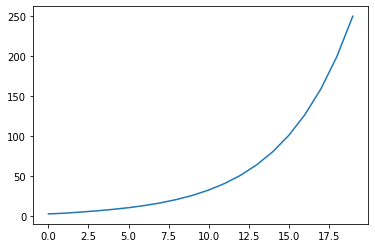

In [37]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터 차원 수 
T = 20 # 시계열 데이터의 길이 

dh = np.ones((N,H))
np.random.seed(3) # 재현할 수 있도록 난수 고정
Wh = np.random.randn(H,H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T) # 역전파의 노드 수 만큼 dh를 갱신
    norm = np.sqrt(np.sum(dh**2)) / N # dh의 크기 : L2 norm 사용
    norm_list.append(norm) # 각 단계에서 dh의 크기를 norm_list에 추가
    
plt.plot(norm_list)
plt.show()

기울기가 시간에 비례해 지수적으로 증가함! 이것이 바로 `Exploding Gradients`

기울기 폭발이 일어나면 Overflow를 일으켜 결국 NaN같은 값을 발생시킨다. 신경망 학습이 제대로 수행 안 됨.

### 기울기 실험 2

```python
# Wh = np.random.randn(H,H) # 변경 전
Wh = np.random.randn(H,H) * 0.5 # 변경 후
```

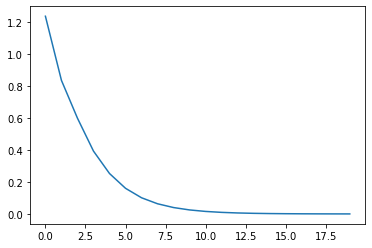

In [24]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터 차원 수 
T = 20 # 시계열 데이터의 길이 

dh = np.ones((N,H))
np.random.seed(3) # 재현할 수 있도록 난수 고정
#Wh = np.random.randn(H,H) # 변경 전
Wh = np.random.randn(H,H) * 0.5 # 변경 후

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T) # 역전파의 노드 수 만큼 dh를 갱신
    norm = np.sqrt(np.sum(dh**2)) / N # dh의 크기 : L2 norm 사용
    norm_list.append(norm) # 각 단계에서 dh의 크기를 norm_list에 추가
    
plt.plot(norm_list)
plt.show()

반대로 기울기가 지수적으로 감소함! 이것이 `Vanishinng Gradients`

기울기 소실이 일어나면 기울기가 매우 빠르게 작아져 가중치 매개변수가 더 이상 갱신되지 않아 학습 효과가 발생하지 않음.

### 기울기 소실 혹은 기울기 폭발 원인

이러한 지수적인 변화가 일어나는 이뉴는 행렬 Wh를 T번 반복해서 곱했기 때문

Wh가 스칼라라면? 
   -  1보다 크면 지수적으로 증가하고, 1보다 작으면 지수적으로 감소

Wh가 스칼라가 아니라 행렬이라면?
   - 행렬의 특잇값이 척도가 된다. 
   - 행렬의 특잇값이란, 간단히 말해 데이터가 얼마나 퍼져있는 지를 나타냄.
   - 특잇값의 최댓값이 1보다 크면 지수적으로 증가하고 1보다 작으면 지수적으로 감소할 가능성이 높음..! (안 그럴 수도)

## 기울기 폭발 대책

기울기 폭발의 대책으로 전통적인 기법. 기울기 클리핑 `Gradients clipping`.

$$ {if}\ \lVert \hat{g}\rVert \ge threshold : $$

$$\hat{g} = \frac{threshold}{\lVert \hat{g}\rVert}\hat{g}$$

- $\hat{g}$ ; 기울기 통칭
- $\lVert \hat{g}\rVert$ : L2 norm 

**기울기의 l2 norm이 threshold를 초과하면 두 번째 줄의 수식처럼 기울기를 수정한다. 기울기 깎음.**

In [36]:
import numpy as np

dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0 #threshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
        
    rate = max_norm / (total_norm + 1e-6)
    if total_norm >= max_norm :
        for grad in grads:
            grad *= rate
            
display("clipping 전", grads)
clip_grads(grads,max_norm)
print()
display("clipping 후", grads)

'clipping 전'

[array([[3.40688484, 0.64673198, 8.64119669],
        [2.90872446, 7.41082406, 1.58033655],
        [6.94963435, 8.41419619, 7.27152079]]),
 array([[3.59107525, 7.26689751, 1.39467124],
        [3.13819115, 4.19582757, 8.77212039],
        [1.53740209, 8.8012479 , 7.98964319]])]

'clipping 후'

[array([[0.67320956, 0.12779597, 1.70752359],
        [0.57477174, 1.46439866, 0.31227873],
        [1.37326634, 1.66266768, 1.43687196]]),
 array([[0.70960608, 1.43595839, 0.27559077],
        [0.62011497, 0.82910675, 1.73339446],
        [0.30379477, 1.73915013, 1.57877487]])]

# 기울기 소실과 LSTM

기울기 소실 문제를 해결하기 위해서는 RNN 계층을 갈아엎어야함! 

==> **게이트가 추가된 RNN**. 대표적인 신경망에는 LSTM과 GRU가 있다.

이번 장에서는 LSTM에 집중하고 도식은 간소화하여 설명함

## LSTM의 인터페이스

<img src = "../imgs/fig 6-11.png" width = "600" align = "center">

- LSTM 계층의 인터페이스에는 **c**라는 경로가 있다
    - **이 c은 `memory cell` 혹은 `cell` 이라고 하며, LSTM 전용의 기억 매커니즘이다.**
    - 기억 셀은 LSTM 계층 내에서만 작동. LSTM 계층 내에서만 완결되고, 다른 계층으로는 출력하지 않음.
    
    
- LSTM의 은닉 상태 h는 RNN 계층과 마찬가지로 가른 계층으로 출력됨.

## LSTM 계층 조립하기

- LSTM에는 시각 t에서의 LSTM의 기억이 저장된 **기억 셀 $c_t$가 있다.** 
- 이때 c에는 과거로부터 시각 t까지에 필요한 모든 정보가 저장되어 있다고 가정하자.
- 이 모든 정보를 담고 외부 계층에 은닉 상태 $h_t$를 출력한다. (이때 출력값은 기억 셀을 tanh함수로 변환한 값)

 <center> 기억 셀 $c_t$는 입력 ($c_{t-1}, h_{t-1}, x_t$)으로부터 어떤 계산을 거쳐 구해진다! </center>

#### <center> 핵심은 갱신된 $c_t$를 활용해 은닉 상태 $h_t$를 계산한다는 것 </center>

$$h_t = tanh(c_t)$$

---

- 또한 LSTM 에는 `게이트`라는 기능이 존재한다
    - 열기/닫기
    - 어느 정도 열지 조절 가능 openness! (0.7 or 0.2...)
        - 게이트의 열림 상태는 0.0-1.0 사이의 실수로 나타난다
        - sigmoid 함수
    - **LSTM 은 이러한 "게이트의 열림 정도"를 <u>데이터로부터 자동으로 학습한다</u>**

## output 게이트 (LSTM의 출력 부분)

<img src = "../imgs/fig 6-15.png" width = "300" align = "center">


은닉상태 $h_t$ = $tanh(c_t)$

- 게이트는 $tanh(c_t)$ 의 각 원소에 대해 **그것이 다음 시각의 은닉 상태에 얼마나 중요한가**를 조정한다
- 이 게이트는 다음 은닉 상태 $h_t$의 출력을 담당하는 게이트이므로 `output 게이트` 라고 부른다.


<img src = "../imgs/e 6-1.png" width = "200" align = "center">

1.  output 게이트의 열림 상태는 입력 $x_t$ 이전 상태 $h_{t-1}$로부터 계산한다 
- o : output
- $\sigma$ : sigmoid
- $W^{(o)}$ : 게이트 가중치

2. 계산을 거친 뒤 시그모이드 함수를 거쳐 출력 게이트의 출력 o를 구한다.

3. 마지막으로 이 o와 $tanh(c_t)$의 원소 별 곱을 $h_t$로 출력한다.
    - 원소 별 곱이란 `아다마르 곱` (Hadamard product) 이라고도 한다.
    - $\odot$

<img src = "../imgs/e 6-2.png" width = "150" align = "center">

[참고]

- tanh
    - -1.0 -1.0의 실수.
    - 인코딩된 정보의 "강약 정도"라고 해석
    - **실질적인 정보를 지니는 데이터에 사용됨**
- sigmoid 
    - 0.0-1.0의 실수. 
    - 데이터를 얼마만큼 통과시킬 지를 정하는 비율
    - **게이트에서 주로 사용됨**

## forget 게이트 (망각 게이트)

<img src = "../imgs/fig 6-16.png" width = "300" align = "center">

- $c_{t-1}$의 기억 정보 중에서 불필요한 정보를 잊게 해주는 게이트

<img src = "../imgs/e 6-3.png" width = "200" align = "center">

- f : forget 게이트의 출력
- 이 f와 이전 기억 셀인 $c_{t-1}$과의 원소 별 곱, 즉 $c_{t} = {f}\odot{c_{t-1}}$ 를 계산

## 새로운 기억 셀

- forget 게이트를 거치면서 이전 계층의 기억 셀로부터 지워야 할 정보가 삭제되었다
- but 이 상태로는 기억 셀 c가 잊는 것 밖에 하지 못함. 
- **새로 기억할 정보를 기억 셀 c에 추가해야됨.**

<img src = "../imgs/fig 6-17.png" width = "300" align = "center">

- tanh 노드가 계산한 결과가 이전 시각의 기억 셀 $c_{t-1}$에 더해진다
- tanh 노드는 게이트가 아니고! 새로운 정보를 기억 셀에 추가해주는 역할

<img src = "../imgs/e 6-4.png" width = "250" align = "center">

- g가 이전 시각 기억 셀 $c_{t-1}$에 더해짐으로써 새로운 기억이 생겨난다

## input 게이트 (입력 게이트)

<img src = "../imgs/fig 6-18.png" width = "300" align = "center">

- input 게이트는 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰 지 판단. 가중 or 축소

<img src = "../imgs/e 6-5.png" width = "200" align = "center">

- i와 g의 원소별 곱 결과를 기억 셀에 추가

## LSTM의 기울기 흐름

**RNN과 다르게 기울기 소실이 일어나지 않는 이유**

똑같은 가중치 행렬을 사용하여 행렬 곱을 반복하여 기울기 소실 혹은 기울기 폭발을 일으켰던 RNN과 다르게,   
매 시각 다른 게이트 값을 이용해 원소 별 곱을 계산. 곱셈의 효과가 누적되지 않는다.

<요약>
1. 행렬 곱 아닌 원소별 곱(아다마르 곱)
2. 매 시각 다른 게이트 값 사용 (곱셈 누적 x)

LSTM = Long Short-Term Memory, **단기 기억**을 **긴 시간 지속**할 수 있음

# LSTM 구현

<img src = "../imgs/e 6-6.png" width = "200" align = "center">
<center>$xW_x + hW_h + b$ 형태의 아핀 변환 (행렬 변환과 평행 이동을 결합한 형태)</center>

---

#### <center>위 4개의 식은 하나의 형태로 표현 가능하다</center>

$$x_t W_x^{(f)} + h_{t-1} W_h^{(f)} + b^{(f)} $$
$$x_t W_x^{(g)} + h_{t-1} W_h^{(g)} + b^{(g)} $$
$$x_t W_x^{(i)} + h_{t-1} W_h^{(i)} + b^{(i)} $$
$$x_t W_x^{(o)} + h_{t-1} W_h^{(o)} + b^{(o)} $$

<img src = "../imgs/fig 6-20 fixed.png" width = "400" align = "center">

#### <center>*** 4번 수행하던 아핀 변환을 1회의 계산으로 가능하게 함 ***</center> 


---
그 외 수식

<img src = "../imgs/e 6-7.png" width = "150" align = "center">
<img src = "../imgs/e 6-8.png" width = "150" align = "center">

<img src = "../imgs/fig 6-21.png" width = "600" align = "center">

- 처음 4개 분의 아핀 변환을 한꺼번에 수행
- slice 노드를 통해 그 4개의 결과를 꺼냄 ( f g i o )
- slice 노드 다음에 활성화 함수 (시그모이드 or tanh)를 거친다

In [1]:
class LSTM:
    # 초기화 코드
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None # 순전파 결과 보관용
    
    # 순전파
    def forward(self, x, h_prev, c_prev): # 현시각의 입력, 이전 시각의 은닉 상태, 이전 시각의 기억 셀
        Wx, Wh, b = self.params 
        N, H = h_prev.shape 
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b # 4개의 아핀 변환 결과 동시 처리 4H 만큼
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
   
    # 역전파
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
    
        ds = dc_next + (dh_next * o) * (1 - np.tanh(c_next) ** 2)
        
        dc_prev = ds * f
        
        # 게이트 
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i) 
        df *= f * (1 - f) 
        do *= o * (1 - o) 
        dg *= (1 - g ** 2) 
        
        
        dA = np.hstack((df, dg, di, do)) # 4개의 행렬 연결
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis = 0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

## Time LSTM 구현

T개분의 시계열 데이터 한꺼번에 처리하는 계층

<img src = "../imgs/fig 6-24.png" width = "600" align = "center">

<img src = "../imgs/fig 6-25.png" width = "600" align = "center">

- RNN과 마찬가지로 Truncated BPTT 학습
    - 역전파의 연결을 적당한 길이로 끊는다
    - **`순전파의 흐름은 유지!!`**
    - 은닉 상태와 기억 셀을 인스턴스 변수로 유지하여 다음번 forward가 불렸을 때 이전 시각부터 시작할 수 있도록

In [3]:
class TimeLSTM:
    # 초기화 코드
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeors((N,H), dtype='f')
        if not self.stateful or self.c is None:
            self.c= np.zeors((N,H), dtype='f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:,t,:] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)): # 역전파라서 reversed
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layㅁer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

# LSTM 을 사용한 언어 모델

<img src = "../imgs/fig 6-26.png" width = "600" align = "center">

RNN 혹은 LSTM. 신경망만 다르게 !

In [10]:
import sys
sys.path.append("..")
from common.time_layers import *
import pickle


class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):

        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')  # Xavier 초기화
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')  # Xavier 초기화
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_lyaer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기 리스트에 모음
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads


    # 문장 생성
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    # 매개변수 읽기 / 쓰기
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, "wb") as f:
            pickle.dump(self.params, f)

    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, "rb") as f:
            self.params = pickle.load(f)

In [1]:
import numpy as np
import sys
sys.path.append("..")
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNN 은닉 상태 벡터의 원소 수 
time_size = 35 # RNN 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:] # target

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

########################################
# 1 - 기울기 클리핑 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, 
            eval_interval=20) # 20번째 반복마다 퍼플렉시티 평가하라
trainer.plot(ylim=(0,500))

# 2 - 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test) # 모델 상태를 재설정하여 평가를 수행
print("테스트 퍼플렉시티: ",ppl_test)

# 3 - 학습 완료된 매개변수들을 파일로 저장
model.save_params()
########################################

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.13
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 3104.35
| 에폭 1 |  반복 41 / 1327 | 시간 11[s] | 퍼플렉서티 1256.38
| 에폭 1 |  반복 61 / 1327 | 시간 18[s] | 퍼플렉서티 998.92
| 에폭 1 |  반복 81 / 1327 | 시간 24[s] | 퍼플렉서티 795.90
| 에폭 1 |  반복 101 / 1327 | 시간 30[s] | 퍼플렉서티 692.68
| 에폭 1 |  반복 121 / 1327 | 시간 36[s] | 퍼플렉서티 653.10
| 에폭 1 |  반복 141 / 1327 | 시간 41[s] | 퍼플렉서티 613.26
| 에폭 1 |  반복 161 / 1327 | 시간 46[s] | 퍼플렉서티 586.16
| 에폭 1 |  반복 181 / 1327 | 시간 51[s] | 퍼플렉서티 592.12
| 에폭 1 |  반복 201 / 1327 | 시간 56[s] | 퍼플렉서티 514.07
| 에폭 1 |  반복 221 / 1327 | 시간 61[s] | 퍼플렉서티 487.43
| 에폭 1 |  반복 241 / 1327 | 시간 67[s] | 퍼플렉서티 447.01
| 에폭 1 |  반복 261 / 1327 | 시간 73[s] | 퍼플렉서티 457.47
| 에폭 1 |  반복 281 / 1327 | 시간 78[s] | 퍼플렉서티 464.87
| 에폭 1 |  반복 301 / 1327 | 시간 84[s] | 퍼플렉서티 390.11
| 에폭 1 |  반복 321 / 1327 | 시간 89[s] | 퍼플렉서티 349.28
| 에폭 1 |  반복 341 / 1327 | 시간 94[s] | 퍼플렉서티 408.34
| 에폭 1 |  반복 361 / 1327 | 시간 99[s] | 퍼플렉서티 407.41
| 에폭 1 |  반복 381 / 1327 | 시간 104[s] | 퍼플렉서티 338.00
| 에

<Figure size 640x480 with 1 Axes>

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉시티:  136.2600433175287


In [2]:
# 2 - 테스트 데이터로 평가
ppl_test = eval_perplexity(model, corpus_test) # 모델 상태를 재설정하여 평가를 수행
print("테스트 퍼플렉시티: ",ppl_test)

# 3 - 학습 완료된 매개변수들을 파일로 저장
model.save_params()
########################################

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉시티:  136.30010584700165


# RNNLM 추가 개선

- 개선 포인트 3가지 설명

## LSTM 계층 다층화

많은 경우 LSTM을 2층, 3층 등으로 여러 개 쌓아 더 나은 정확도의 모델을 기대할 수 있다.

<img src = "../imgs/fig 6-29.png" width = "500" align = "center">

- 첫 번째 LSTM 계층의 은닉 상태가 두 번째 LSTM 계층에 입력된다
- 구글 번역에서 사용하는 GNMT 모델은 LSTM 을 8층 쌓은 신경망!
- **데이터의 개수에 따라 적절하게 쌓는 것이 중요하다**

## Dropout에 의한 overfitting 억제

- 층을 깊게 쌓으면 정확한 모델을 얻을 수 있다는 장점이 있으나, `과적합 overfitting` 을 일으킬 수 있다!
- 일반적으로 RNN 계열 모델이 더 과적합에 약하다
- 그러므로 RNN계열 모델을 사용한다면 과적합 억제 방법을 적용시키는 것이 필수!

---

### overfitting 방지
1. 훈련 데이터 양 늘리기
2. 모델의 복잡도 줄이기

3. 그 외) 모델 복잡도에 페널티를 주는 정규화 (normalization) 방식
    - L2 정규화는 가중치가 너무 커지면 페널티를 부과한다 
    - `Dropout`이 정규화의 일종임

### Dropout

**RNN 모델에 Dropout 계층을 어디에 삽입해야 할까?**

<img src = "../imgs/fig 6-32.png" width = "700" align = "center">

- 드롭아웃 계층을 시계열 방향으로 넣기
    - **학습 시 시간의 흐름에 따라 정보가 사라질 수 있다**
    - 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적된다..! NO!

<img src = "../imgs/fig 6-33.png" width = "600" align = "center">

- 드롭아웃 계층을 깊이 방향 넣기
    - 시간 방향에 비례하여 정보 소실이 일어나지 않는다 
    - 시간과 상관없이 독립적으로 영향주기
    - **`Variational Dropout` : 시간 방향의 드롭아웃**
    - <img src = "../imgs/fig 6-34.png" width = "650">
    - 같은 계층의 드롭아웃끼지 같은 마스크를 공유함으로써 마스크가 고정된다 
    - 정보를 잃게 되는 압버도 고정되므로, 일반적인 드롭아웃 때와 달리 정보가 지수적으로 손실되는 사태 막음

## 개선된 RNNLM 구현

<img src = "../imgs/fig 6-36.png" width = "300" align = "center">

- 개선점은 다음 세가지 

    - LSTM 계층의 다층화
    - 드롭아웃 사용 ( 깊이 방향 )
    - 가중치 공유 ( Embedding 계층과 Affine 계층에서 가중치 공유 )

In [1]:
import sys
import numpy as np
sys.path.append("..")
from common.time_layers import *
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')  # Xavier 초기화
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')  # Xavier 초기화
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')  # Xavier 초기화
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')  # Xavier 초기화
        lstm_b2 = np.zeros(4 * H).astype('f')
        # affine_W = (rn(H, V) / np.sqrt(H)).astype('f') # embed와 공유할라공
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # 가중치 공유!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        # 모든 가중치와 기울기 리스트에 모음
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    # 문장 생성
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [1]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5 

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf') # 무한대로 초기 설정
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    # 검증 데이터 퍼플렉시티가 best ppl 보다 낮으면 학습률을 1/4로 줄임
    if best_ppl > ppl: 
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)

| 에폭 1 |  반복 1 / 1327 | 시간 5[s] | 퍼플렉서티 10000.00


KeyboardInterrupt: 

In [ ]:
# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

## 퍼플렉시티 75!